In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import openpyxl
%matplotlib inline

In [2]:
import os

In [4]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
processed_dir = TOP + 'data/processed/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'
refs_dir = TOP + 'references/'

## Visualising ELSIE, LRI, Munro and ToxVal datasets through ToxPrints

In [53]:
elsie = pd.read_csv(processed_dir+'output_elsie290322.txt', sep = ';')

In [54]:
elsie.columns[-1] 

'M_CORINA_SYMPHONY_ERRORS_[STRING]'

In [55]:
elsie = elsie[elsie['M_CORINA_SYMPHONY_ERRORS_[STRING]'] == 'No errors']

In [56]:
elsie = elsie.iloc[:, :-2]

In [222]:
elsie.shape

(414, 730)

In [221]:
#elsie.index.tolist()

In [18]:
toxval = pd.read_csv(processed_dir+'output_ToxVal290322.txt', sep = ';')

In [22]:
toxval['M_CORINA_SYMPHONY_ERRORS_[STRING]'].value_counts()

No errors    4344
Name: M_CORINA_SYMPHONY_ERRORS_[STRING], dtype: int64

In [28]:
toxval = toxval.iloc[:,:-2]

In [76]:
toxval

,M_NAME,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
0,DTXSID001004378,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DTXSID001005033,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,DTXSID001006300,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DTXSID001014567,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DTXSID001014636,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,DTXSID90961393,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4340,DTXSID90965533,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4341,DTXSID90972929,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4342,DTXSID90990466,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
munro = pd.read_csv(external_dir + 'Munro_toxprints.tsv', sep = '\t')

#### Translation of 729 ToxPrints into Level 2 condensed ToxPrints for profiling purposes

In [30]:
txpts = pd.read_csv(refs_dir+'toxprint_V2.0_r711_5Levels.csv')

In [31]:
level2_dict = {}
for x,y in txpts.groupby(['Level 2 full']):
    k = [e for e in y['Level 2 full'] if e!= ' '][0]
    v = set(y['ToxPrint_chemotype_name (original)'])
    level2_dict[k]=v

In [78]:
def prep_df(df, ID = 'M_NAME'):
    df2 = df.copy()
    df3 = pd.melt(df2,id_vars= ID, value_vars = df2.columns[1:])
    df3 = df3.replace(0, np.nan)
    df3.dropna(axis = 0, how = 'any', inplace = True)
    df3.rename(columns={'variable': 'toxprint'}, inplace=True)
    return df3

In [79]:
elise_tps_long = prep_df(elsie, ID = 'M_NAME')

In [81]:
munro_tps_long = prep_df(munro, ID = 'M_name')

In [131]:
toxval_tps_long = prep_df(toxval, ID='M_NAME')

#### Create aggregate ToxPrint counts

In [84]:
tag = {e:k for e in elise_tps_long['toxprint'] for k,v in level2_dict.items() if e in v}

In [86]:
elise_tps_long['aggregate_toxprint'] = elise_tps_long['toxprint'].replace(tag)

In [133]:
tag2 = {e:k for e in toxval_tps_long['toxprint'] for k,v in level2_dict.items() if e in v}

In [134]:
toxval_tps_long['aggregate_toxprint'] = toxval_tps_long['toxprint'].replace(tag2)

In [135]:
tag3 = {e:k for e in munro_tps_long['toxprint'] for k,v in level2_dict.items() if e in v}

In [136]:
munro_tps_long['aggregate_toxprint'] = munro_tps_long['toxprint'].replace(tag3)

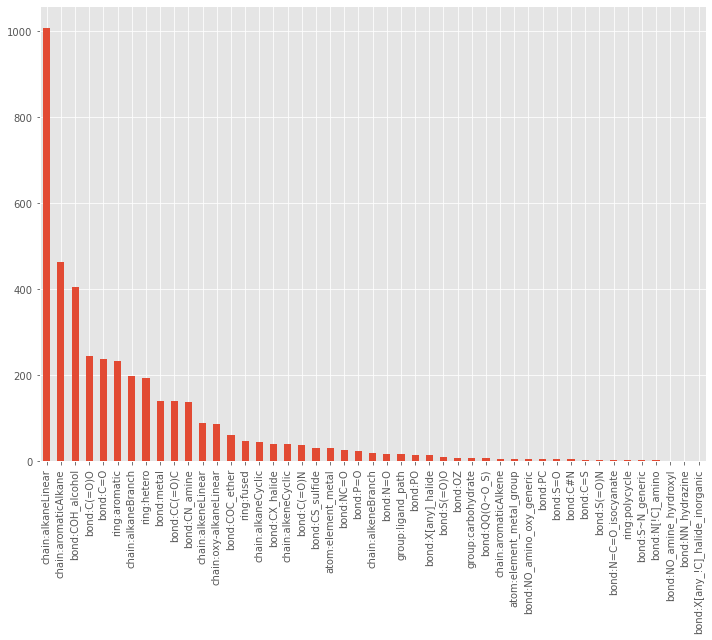

In [92]:
plt.style.use('ggplot')
plt.figure(figsize= (10,9))
elise_tps_long.aggregate_toxprint.value_counts().plot.bar()
plt.tight_layout()

In [93]:
df_chunk = pd.read_csv(raw_dir+'lri_txps_140220.csv', chunksize=1000)

chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in df_chunk:  
    # perform data filtering 
    #chunk_filter = chunk_preprocessing(chunk)
    
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    
# concat the list into dataframe 
lri_tps = pd.concat(chunk_list)


In [94]:
lri_tps.shape

(45038, 732)

In [97]:
lri_tps = lri_tps[lri_tps['M_CORINA_SYMPHONY_ERRORS_[STRING]'] == 'No errors']

In [98]:
lri_tps = lri_tps.iloc[:,:-2]

In [107]:
lri_tps_long = prep_df(lri_tps, ID = 'M_NAME')

In [108]:
lri_tps_long

,M_NAME,toxprint,value
39092,DTXSID4026399,atom:element_main_group,1.0
44928,DTXSID7021235,atom:element_metal_group_I_II,1.0
44930,DTXSID7021233,atom:element_metal_group_I_II,1.0
44933,DTXSID2041705,atom:element_metal_group_I_II,1.0
44942,DTXSID9025328,atom:element_metal_group_I_II,1.0
...,...,...,...
32695775,DTXSID8022117,ring:polycycle_tricyclo_adamantane,1.0
32700138,DTXSID00173425,ring:polycycle_tricyclo_adamantane,1.0
32700141,DTXSID10175854,ring:polycycle_tricyclo_adamantane,1.0
32700150,DTXSID5022017,ring:polycycle_tricyclo_adamantane,1.0


In [109]:
tag4 = {e:k for e in lri_tps_long['toxprint'] for k,v in level2_dict.items() if e in v}

In [110]:
lri_tps_long['aggregate_toxprint'] = lri_tps_long['toxprint'].replace(tag4)

#### Creating a countplot for all datasets

In [119]:
lri_bar = lri_tps_long.aggregate_toxprint.value_counts().reset_index()

In [120]:
lri_bar.rename(columns = {'index' : 'Txp', 'aggregate_toxprint' : 'count'}, inplace = True)

In [121]:
lri_bar.head()

,Txp,count
0,ring:hetero,74239
1,chain:alkaneLinear,65599
2,bond:CN_amine,53708
3,bond:COH_alcohol,43410
4,chain:aromaticAlkane,39827


In [122]:
elise_bar = elise_tps_long.aggregate_toxprint.value_counts().reset_index()

In [124]:
elise_bar.rename(columns = {'index' : 'Txp', 'aggregate_toxprint' : 'count'}, inplace = True)

In [125]:
lri_elise = pd.merge(lri_bar, elise_bar, on = 'Txp' , how = 'outer')

In [126]:
lri_elise.rename(columns = {'count_x': 'LRI_count', 'count_y': 'ELSIE_count'}, inplace = True)

In [127]:
lri_elise.head()

,Txp,LRI_count,ELSIE_count
0,ring:hetero,74239,194.0
1,chain:alkaneLinear,65599,1007.0
2,bond:CN_amine,53708,138.0
3,bond:COH_alcohol,43410,404.0
4,chain:aromaticAlkane,39827,463.0


In [138]:
toxval_bar = toxval_tps_long.aggregate_toxprint.value_counts().reset_index()
toxval_bar.rename(columns = {'index' : 'Txp', 'aggregate_toxprint' : 'count'}, inplace = True)
toxval_bar

,Txp,count
0,chain:alkaneLinear,6783
1,ring:hetero,4388
2,bond:CN_amine,3587
3,bond:CX_halide,3449
4,bond:COH_alcohol,3373
...,...,...
57,group:nucleobase,6
58,chain:oxy-alkaneBranch,4
59,bond:NN=N_triazene,3
60,bond:P(=O)N,3


In [139]:
lri_elise_txval = pd.merge(lri_elise, toxval_bar, on = 'Txp' , how = 'outer')
lri_elise_txval

,Txp,LRI_count,ELSIE_count,count
0,ring:hetero,74239,194.0,4388.0
1,chain:alkaneLinear,65599,1007.0,6783.0
2,bond:CN_amine,53708,138.0,3587.0
3,bond:COH_alcohol,43410,404.0,3373.0
4,chain:aromaticAlkane,39827,463.0,3328.0
...,...,...,...,...
65,bond:N=[N+]=[N-]_azide,38,NaN,1.0
66,bond:Se~Q,24,NaN,NaN
67,bond:P=O_phosphonate_thio_dimethyl_methylphosp...,11,NaN,NaN
68,bond:P=C_phosphorane_generic,1,NaN,NaN


In [140]:
lri_elise_txval.rename(columns = {'count': 'ToxValDB_count'}, inplace = True)

In [141]:
munro_bar = munro_tps_long.aggregate_toxprint.value_counts().reset_index()
munro_bar.rename(columns = {'index' : 'Txp', 'aggregate_toxprint' : 'count'}, inplace = True)
munro_bar

,Txp,count
0,bond:CX_halide,838
1,ring:hetero,777
2,bond:COH_alcohol,602
3,chain:alkaneLinear,531
4,chain:aromaticAlkane,488
...,...,...
56,bond:quatS,1
57,bond:NN=N_triazene,1
58,bond:CNO_amineOxide,1
59,atom:element_metal,1


In [142]:
lri_elise_txval_munro = pd.merge(lri_elise_txval, munro_bar, on = 'Txp' , how = 'outer')

In [143]:
lri_elise_txval_munro.rename(columns = {'count': 'Munro_count'}, inplace = True)

In [166]:
lri_elise_txval_munro.sort_values(by = ['LRI_count', 'ToxValDB_count', 'Munro_count'], ascending = [False, False, False])

,Txp,LRI_count,ELSIE_count,ToxValDB_count,Munro_count
0,ring:hetero,74239,194.0,4388.0,777.0
1,chain:alkaneLinear,65599,1007.0,6783.0,531.0
2,bond:CN_amine,53708,138.0,3587.0,473.0
3,bond:COH_alcohol,43410,404.0,3373.0,602.0
4,chain:aromaticAlkane,39827,463.0,3328.0,488.0
...,...,...,...,...,...
65,bond:N=[N+]=[N-]_azide,38,NaN,1.0,NaN
66,bond:Se~Q,24,NaN,NaN,NaN
67,bond:P=O_phosphonate_thio_dimethyl_methylphosp...,11,NaN,NaN,1.0
68,bond:P=C_phosphorane_generic,1,NaN,NaN,NaN


In [151]:
lri_elise_txval_munro[lri_elise_txval_munro.ELSIE_count.isnull()]

,Txp,LRI_count,ELSIE_count,ToxValDB_count,Munro_count
23,group:aminoAcid,4401,NaN,206.0,21.0
26,bond:N(=O),3157,NaN,291.0,74.0
28,bond:quatN,2770,NaN,139.0,11.0
31,bond:C=N,2217,NaN,168.0,24.0
37,bond:N=N_azo,1504,NaN,422.0,30.0
38,bond:C(~Z)~C~Q,1255,NaN,85.0,22.0
44,group:nucleobase,709,NaN,6.0,4.0
50,bond:X~Z,490,NaN,25.0,NaN
52,chain:alkyne_ethyne_generic,471,NaN,25.0,3.0
53,bond:P~S_generic,321,NaN,62.0,23.0


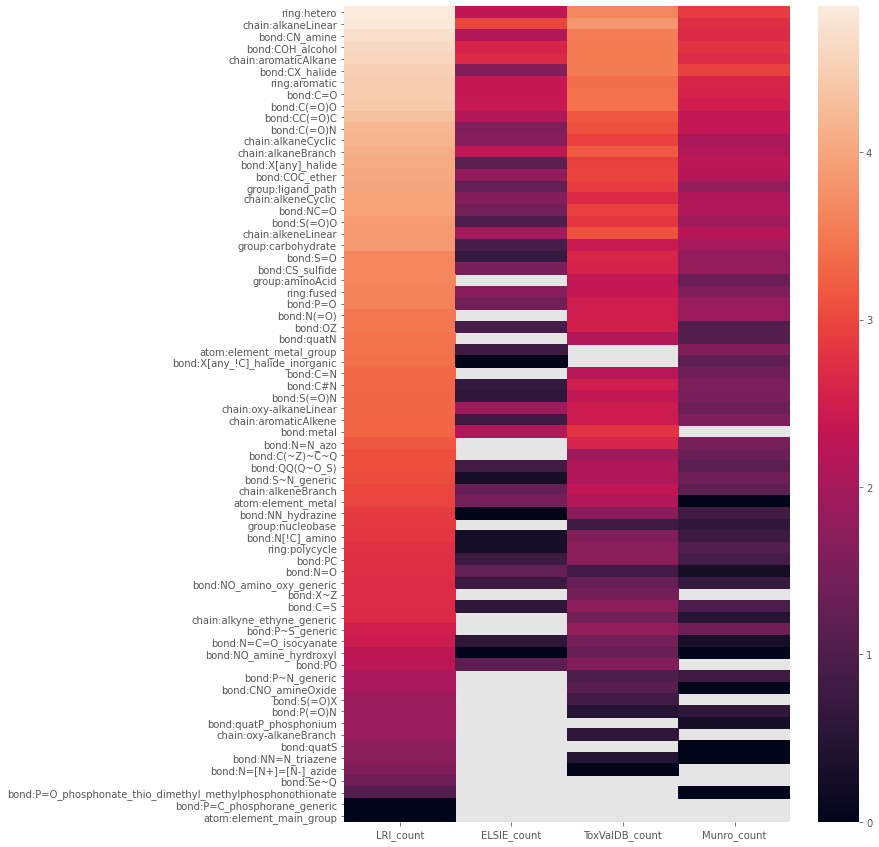

In [162]:
plt.figure(figsize = (10,15))
sns.heatmap(np.log10(lri_elise_txval_munro.iloc[:,1:]), yticklabels= lri_elise_txval_munro.iloc[:,0])
plt.savefig(figures_dir+'toxprints_heatmap_290322.png', bbox_inches='tight', dpi=300)

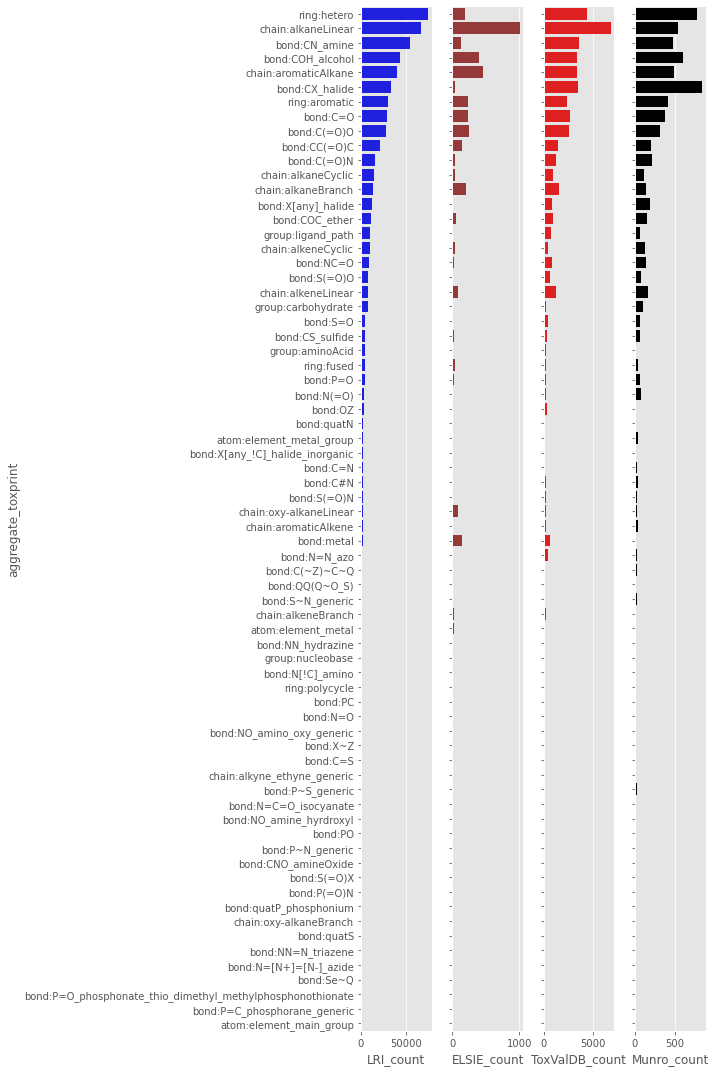

In [163]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(10,15), sharey = True)


sns.barplot(x = 'LRI_count', y = 'Txp', color = 'blue',label = "lri", data = lri_elise_txval_munro, ax=ax1)
sns.barplot(x = 'ELSIE_count', y = 'Txp', color = 'brown',label = "Elise", data = lri_elise_txval_munro, ax = ax2)
sns.barplot(x = 'ToxValDB_count', y = 'Txp', color = 'red',label = "ToxValDB", data = lri_elise_txval_munro, ax=ax3)
sns.barplot(x = 'Munro_count', y = 'Txp', color = 'black',label = "Munro", data = lri_elise_txval_munro, ax = ax4)


ax1.set_ylabel('aggregate_toxprint')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')


ax1.set_xlabel('LRI_count')
ax2.set_xlabel('ELSIE_count')
ax3.set_xlabel('ToxValDB_count')
ax4.set_xlabel('Munro_count')
plt.tight_layout()

f.savefig(figures_dir+'toxprints_comparison_290322.png', dpi = 300)

#### Generating dataset for TSNE and UMAP projections

In [168]:
elsie.head()

,M_NAME,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
0,DTXSID2066561,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DTXSID3067815,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,DTXSID3026564,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DTXSID4024696,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DTXSID9021847,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
elsie['Source'] = 'ELSIE'
elsie = elsie.set_index('M_NAME')

In [171]:
munro = munro.set_index('M_name')
munro['Source'] = 'MUNRO'

In [173]:
toxval = toxval.set_index('M_NAME')
toxval['Source'] = 'TOXVAL'

In [175]:
lri_tps.head()

,M_NAME,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
0,DTXSID6020561,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DTXSID9020453,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,DTXSID3034456,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DTXSID2024242,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DTXSID4032376,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
lri_tps = lri_tps.set_index('M_NAME')

In [177]:
lri_tps['Source'] = 'LRI'

In [187]:
elsie

,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,bond:C#N_cyano_cyanohydrin,...,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene,Source
M_NAME,,,,,,,,,,,,,,,,,,,,,
DTXSID2066561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ELSIE
DTXSID3067815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ELSIE
DTXSID3026564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ELSIE
DTXSID4024696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ELSIE
DTXSID9021847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ELSIE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID5042328,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ELSIE
DTXSID40864845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ELSIE
DTXSID4027286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ELSIE


In [190]:
all_tps = pd.concat([lri_tps, elsie, toxval, munro],axis = 0)

In [215]:
all_tps.to_csv(processed_dir+'all_tps_4UMAP.csv')

#### Investigating means of visualising the 729 ToxPrints into 2-3 Dimensions - exploration of t-TSNE approaches

In [188]:
from sklearn.feature_selection import VarianceThreshold

In [192]:
sel = VarianceThreshold(threshold = (0*(1-0)))
X = sel.fit_transform(all_tps.iloc[:,:-1])

In [193]:
X_df = all_tps.iloc[:,:-1][all_tps.iloc[:,:-1].columns[sel.get_support(indices=True)]]

In [194]:
X_df1 = pd.concat([X_df,all_tps.iloc[:,-1]],axis =1)

In [195]:
X_df1.Source.value_counts()

LRI       44920
TOXVAL     4344
MUNRO       613
ELSIE       414
Name: Source, dtype: int64

In [213]:
X_df1.to_csv(processed_dir+'all_tps_4UMAP.csv')

In [199]:
from sklearn.model_selection import train_test_split

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X_df1.iloc[:,:600], X_df1.iloc[:,600], test_size=0.1, stratify=X_df1.iloc[:,600])

In [201]:
y_test.head()

DTXSID50860055       LRI
DTXSID00507403       LRI
DTXSID90193536       LRI
DTXSID3032541     TOXVAL
DTXSID20207019       LRI
Name: Source, dtype: object

In [202]:
from sklearn.manifold import TSNE

In [203]:
model_txps = TSNE(learning_rate = 200)

In [204]:
tsne_features = model_txps.fit_transform(X_test)

In [205]:
tsne_df=pd.concat([pd.DataFrame(tsne_features, index = X_test.index, columns = ['tsne_x', 'tsne_y']), y_test],axis =1)

In [210]:
tsne_df.head()

,tsne_x,tsne_y,Source,alpha
DTXSID50860055,-57.287518,-37.538944,LRI,0.3
DTXSID00507403,-58.100449,-3.798970,LRI,0.3
DTXSID90193536,-51.762321,28.952793,LRI,0.3
DTXSID3032541,-20.533697,20.513624,TOXVAL,1.0
DTXSID20207019,23.050411,18.913857,LRI,0.3


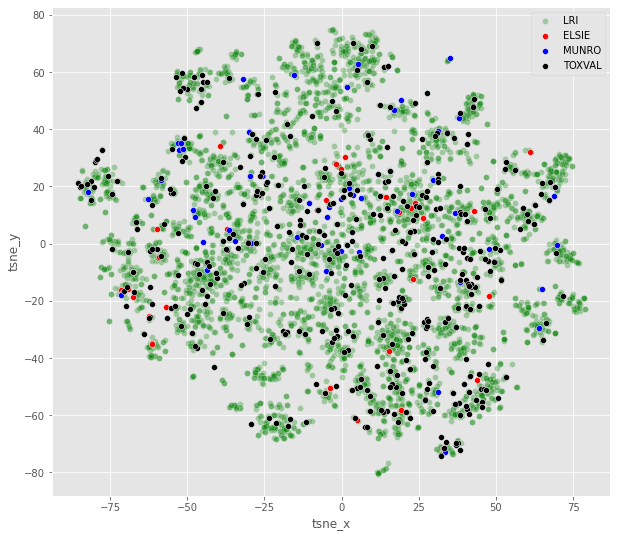

In [212]:
fig, ax = plt.subplots(figsize = (10,9))

colors = {'ELSIE':'red','LRI':'green', 'MUNRO': 'blue', 'TOXVAL' : 'black'}
tsne_df['alpha'] = np.where(tsne_df.Source == 'LRI', 0.3,1)
alphas = tsne_df.alpha.sort_values().unique()
#grouped = tsne_df.groupby('Source')
#for key, group in grouped:
#    group.plot(ax=ax, kind='scatter', x='tsne_x', y='tsne_y', alpha = alphas[0], label=key, color=colors[key])
ax = sns.scatterplot(x="tsne_x", y="tsne_y",
                     data=tsne_df[tsne_df.Source == 'LRI'], alpha=0.3, label = 'LRI', color = colors['LRI'])
ax = sns.scatterplot(x="tsne_x", y="tsne_y",
                    data=tsne_df[tsne_df.Source == 'ELSIE'], alpha=1, label = 'ELSIE', color = colors['ELSIE'])
ax = sns.scatterplot(x="tsne_x", y="tsne_y",
                     data=tsne_df[tsne_df.Source == 'MUNRO'], alpha=1, label = 'MUNRO', color = colors['MUNRO'])
ax = sns.scatterplot(x="tsne_x", y="tsne_y",
                     data=tsne_df[tsne_df.Source == 'TOXVAL'], alpha=1, label = 'TOXVAL', color = colors['TOXVAL'])                 
#plt.title('2D Visualisation of the ELSIE vs LRI Landscape')
plt.savefig(figures_dir+'TxP_2D_Landscape_300322.png', dpi = 300)